In [26]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt 

In [27]:
def trans_importer(start =1, to =1):
    merged = pd.DataFrame()
    for i in range(start,to+1):
        name = "transaction" + str(i) + ".csv" 
        dummy_df = pd.read_csv(name).drop("Unnamed: 0",axis =1)
        merged = pd.concat([merged, dummy_df], ignore_index=True)
    return merged

def article_id_parser(df):
    df = df.dropna(how='all')
    df = df.dropna(subset=['article_id'])
    return df

# Import  data

In [82]:
articles = pd.read_csv('articles.csv')
customers = pd.read_csv('customers.csv')
# we have too large transcation data, so I had to split them up into 10 CSVs, still each over 3milions rows 
trans = trans_importer(1,10)

In [40]:
customers["postal_code"][0]

'52043ee2162cf5aa7ee79974281641c6f11a68d276429a91f8ca0d4b6efa8100'

# Parse data

In [29]:
# parse the transaction data
trans = article_id_parser(trans)
trans

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
9536491,2019-04-30,24c3e18f3a82a73a38dd323edbc0adeabf0134460d8ac4...,735550002,0.008458,2
9536492,2019-04-30,24c3e18f3a82a73a38dd323edbc0adeabf0134460d8ac4...,735550002,0.008458,2
9536493,2019-04-30,24c3e18f3a82a73a38dd323edbc0adeabf0134460d8ac4...,698293001,0.030492,2
9536494,2019-04-30,24c82c6570cf0dc6dbe47749bde8f01fbf8ea75c0bdbe2...,740696001,0.033881,2


# Naive Approach: Item Clustering
This will group the aricle_ids for each customer, which gives a list of item sold for each customer
 - counted_trans : merged transaction data for each customer

In [30]:
# merge articles for each customer
def merger(df):
    df = df.loc[:,["customer_id","article_id"]]
    keys, values = df.sort_values('customer_id').values.T # unpack the keys(customer_id) and values(artical_id)
    ukeys, index = np.unique(keys, return_index = True) # get the index map for each key
    arrays = np.split(values, index[1:]) # cut it by index
    merged = pd.DataFrame({'customer_id':ukeys, 'article_id':[list(i) for i in arrays]}) # merge as data frame
    return merged

In [7]:
merged_trans = merger(trans)
merged_trans # good news is that it has ben shrunken down from 9536496 to 814985 rows!!

,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[625548001, 176209023, 627759010]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[666448006, 640244003, 614854003, 700515001, 6..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[663713001, 578020002, 663713001, 541518023]"
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[698286003, 677049001, 634249005, 707704003]"
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,"[572187001, 478549001, 351933001, 694671001, 6..."
...,...,...
814980,ffffa28cd7ab5d1cbbbfe7b582b1c419270cc0539f3dae...,"[539723001, 506321009, 539723006]"
814981,ffffaff3905b803d1c7e153a1378a5151e1f34f236ba54...,[634825003]
814982,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,"[694182002, 699075005, 722436003, 693242005, 5..."
814983,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,"[720620003, 657924001, 671695001, 624486002, 5..."


# Division by age group
divided into 4 groups by 10 (min: 16.0, max: 99.0)

In [32]:
def age_group_creater(df):
    age_groups = [10.0,20.0,30.0,40.0,float(max(df['age']))]
    customer_age_list = list()
    for i in tqdm(range(len(age_groups)-1)):
        condition = np.logical_and(df.age >=age_groups[i], df.age < age_groups[i+1])
        # customer_age_dict[("customer" + str((i+1)*10))] = df[condition]
        customer_age_list.append(df[condition])
    return customer_age_list

In [81]:
age_list = age_group_creater(customers)
age_list[1] # 20 ages data

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 38.83it/s]


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,NaN,NaN,ACTIVE,NONE,20.0,fe7b8e2b3fafb89ca90db17ffeeae0fd29b795d803f749...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
...,...,...,...,...,...,...,...
1371973,ffffa28cd7ab5d1cbbbfe7b582b1c419270cc0539f3dae...,1.0,1.0,ACTIVE,Regularly,22.0,e89f7536a3d1ff494b6324604db93646fca956d85f8e83...
1371974,ffffaff3905b803d1c7e153a1378a5151e1f34f236ba54...,1.0,1.0,ACTIVE,Regularly,21.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...


In [74]:
tw = age_list[1] # 20 ages data
tw.to_csv("age20.csv",index = False)

In [78]:
age_list[1]["postal_code"].apply(lambda x : len(x)) # 20 ages data

1          64
2          64
6          64
8          64
9          64
           ..
1371973    64
1371974    64
1371975    64
1371976    64
1371977    64
Name: postal_code, Length: 528358, dtype: int64

In [92]:
trans[1:400]

,t_dat,customer_id,article_id,price,sales_channel_id
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001,0.016932,2
...,...,...,...,...,...
395,2018-09-20,0218014619321c250395c5cb9bc9f5323745113f61f3a1...,675281001,0.025407,2
396,2018-09-20,0218014619321c250395c5cb9bc9f5323745113f61f3a1...,663368001,0.050831,2
397,2018-09-20,0218e0970319a0f68ebb78a6cdfffb8ddc461d0d02eeb8...,649057002,0.033881,2
398,2018-09-20,021bfdd3e66576efce4fdffc66c8e7837abad6ac50c10d...,685687001,0.016932,2


In [87]:
unique_postals = np.unique(customers["postal_code"])
len(unique_postals)

352899

# remove redundancy in postal codes

In [91]:
352899/len(customers)

0.25721876412192596

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='club_member_status'>

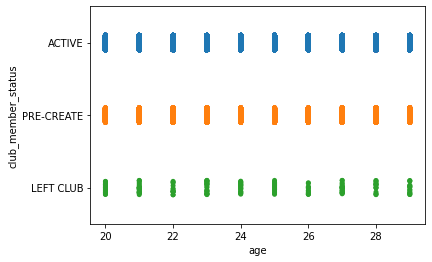

In [73]:
sns.stripplot(tw["age"],tw["club_member_status"],dodge=True)

# Draw top 50 sellers for each age group
 - top50_dict : Dictionary that contains top 50 sellers for each age group
   keys : "age10", "age20", "age30", "age40"
   

In [35]:
def top50_creater(df):
    target_id = df["customer_id"]
    filterd_trans = merged_trans[merged_trans["customer_id"].isin(target_id)]
    article_list = [article for articles in filterd_trans["article_id"] for article in articles]
    article_list = np.unique(article_list,return_counts = True)
    article_list = np.transpose(article_list)
    article_counts = pd.DataFrame(article_list, columns = ['article_id', 'counts'])
    article_counts = article_counts.sort_values(by=["counts"], ascending=False)
    top50 = article_counts[0:99]['article_id']
    return list(top50)

def top50_dictionary(df):
    top50_dict = dict()

    for i,age_group in enumerate(df):
        key = "age"+str((i+1)*10)
        top50_dict[key] = top50_creater(age_group)
    return top50_dict

In [36]:
top50_dict = top50_dictionary(age_list)

In [37]:
top50_dict

{'age10': [539723005,
  706016002,
  706016001,
  539723001,
  399223001,
  399256001,
  673396002,
  684209001,
  372860001,
  706016003,
  683662005,
  464297007,
  507910001,
  689109003,
  701016002,
  636323001,
  689109001,
  539723003,
  372860002,
  673677002,
  624486001,
  680262001,
  599580020,
  539723006,
  351484002,
  539723007,
  507909001,
  554450001,
  621381001,
  484398001,
  529008045,
  684209006,
  701016009,
  706016015,
  706016006,
  156231001,
  663679001,
  609719001,
  573085010,
  501820003,
  610776002,
  501820001,
  572400001,
  681373001,
  692930003,
  599580014,
  448509014,
  759871002,
  664405002,
  179950001,
  640021005,
  692930001,
  599580017,
  574109011,
  529008026,
  605106002,
  516859002,
  108775015,
  709297002,
  399256023,
  712587003,
  351933001,
  673799001,
  663986003,
  709300002,
  701016001,
  589222005,
  554450004,
  701016012,
  572400014,
  685689003,
  657497011,
  715624004,
  573716012,
  701016004,
  554450005,
  6

In [38]:
top50_dict["age20"] # black pants, another black pants black stockings for age group 20

[706016001,
 399223001,
 156231001,
 706016002,
 689109001,
 539723005,
 372860001,
 692930001,
 539723001,
 108775015,
 689109003,
 610776002,
 565379001,
 692930003,
 464297007,
 562245001,
 573716012,
 507910001,
 351484002,
 111593001,
 673396002,
 610776001,
 399256001,
 355072001,
 636455003,
 683662005,
 554450001,
 484398001,
 111586001,
 712587003,
 448509014,
 507909001,
 706016003,
 158340001,
 589222001,
 590928001,
 538699001,
 680262001,
 200182001,
 615141002,
 673677002,
 684209001,
 608776002,
 568601006,
 228257001,
 699075002,
 539723006,
 355072002,
 562245018,
 618800001,
 699075001,
 355569001,
 539723003,
 537116001,
 562245046,
 436261001,
 108775044,
 529012025,
 663679001,
 372860002,
 160442007,
 708352001,
 559633001,
 636323001,
 673901001,
 399136009,
 399223029,
 599580020,
 501820001,
 561445005,
 678715001,
 699077002,
 609719001,
 712587004,
 678694001,
 639192002,
 529008026,
 643985001,
 590928011,
 680263003,
 709297002,
 554450027,
 297067002,
 529